In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import joblib
import numpy as np
from nilearn import plotting

from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.matrices import plot_matrix

ATLAS = "schaeffer"
SOFT = False
ALPHA = 0.05

In [2]:
matrices_path = Path(
    f"{config['data_dir']}/output/connectivity/atlas-{ATLAS}_strategy-high_pass-motion-wm_csf_motion-basic_wm_csf-basic"
)
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [3]:
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
fdrmat = joblib.load(matrices_path / "fdr_mat.joblib")
tstats = joblib.load(matrices_path / "tstats.joblib")


n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

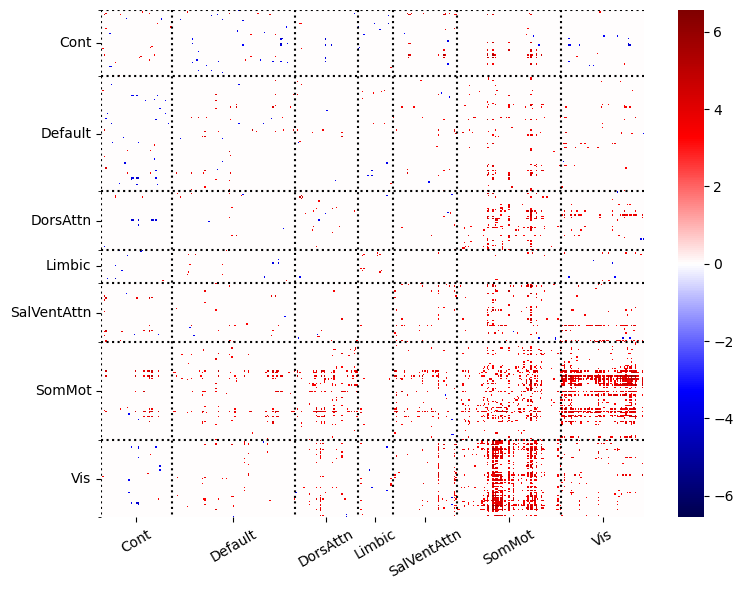

In [4]:
thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
plot_matrix(thresholded_t, atlas)
plt.show()

In [9]:
view = plotting.view_connectome(thresholded_t, coords, edge_threshold="99%")
view.open_in_browser()